In [1]:
import findspark
findspark.init()
import pyspark
import random
import os.path
from pyspark.sql.functions import *

from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
conf = SparkConf()
conf.setMaster("local[1]")
# Introducid el nombre de la app PEC3_ seguido de vuestro nombre de usuario
conf.setAppName("PEC3_emadariagal")
sc = SparkContext(conf=conf)

En esta actividad vamos a trabajar con algortimos de Machine Learning en Spark. 

En esta actividad vamos a trabajar con algortimos de Machine Learning en Spark para analizar un dataset que el gobierno Mexicano publica diariamente. Se trata de un dataset muy completo sobre la COVID-19 con todos los pacientes testeados para covid y sus caracteristicas clinicas y demogŕaficas. Nuestro objetivo es hacer modelos sobre datos clínicos de pacientes COVID en México para predecir el ingreso en UCI en base a las varibales disponibles.

En el siguiente github podeis encontrar los datos y en el fichero descriptores.csv teneis la descripción de las variables que tiene el dataset. 
https://github.com/coronamex/datos/tree/master/util/datos_abiertos_catalogo

El fichero con los datos ya lo hemos copiado en una ruta del servidor para facilitar la práctica.

**Nuestro objetivo será estudiar los datos de COVID de esta base de datos y predecir el ingreso en UCI de los pacientes utilizando las variables disponibles.**

La práctica se compone de las siguientes partes y puntuaciones.

    1) Carga de datos y seleccion de variables 1 PUNTO

    2) Analisis descriptivo y limpieza de datos 2 PUNTO

    3) Análisis visual 2 PUNTO

    4) Regresión logistica 3 PUNTO

    5) Arbol de decisión. 2 PUNTO


## Carga de datos y seleccion de variables

In [2]:
sqlContext = SQLContext(sc)

df = sqlContext.read.csv(
    path="file:///22.519/data/base_de_datos_covid.csv",
    header="true",
    inferSchema="true",
    quote='"',
    sep= ","
)

In [3]:
df.printSchema()

root
 |-- FECHA_ACTUALIZACION: timestamp (nullable = true)
 |-- ID_REGISTRO: string (nullable = true)
 |-- ORIGEN: integer (nullable = true)
 |-- SECTOR: integer (nullable = true)
 |-- ENTIDAD_UM: integer (nullable = true)
 |-- SEXO: integer (nullable = true)
 |-- ENTIDAD_NAC: integer (nullable = true)
 |-- ENTIDAD_RES: integer (nullable = true)
 |-- MUNICIPIO_RES: integer (nullable = true)
 |-- TIPO_PACIENTE: integer (nullable = true)
 |-- FECHA_INGRESO: timestamp (nullable = true)
 |-- FECHA_SINTOMAS: timestamp (nullable = true)
 |-- FECHA_DEF: string (nullable = true)
 |-- INTUBADO: integer (nullable = true)
 |-- NEUMONIA: integer (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- NACIONALIDAD: integer (nullable = true)
 |-- EMBARAZO: integer (nullable = true)
 |-- HABLA_LENGUA_INDIG: integer (nullable = true)
 |-- INDIGENA: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- EPOC: integer (nullable = true)
 |-- ASMA: integer (nullable = true)
 |-- INMUS

Como nuestro objetivo es hacer un analisis sobre datos COVID, lo primero que vamos a hacer es filtrar el conjunto de datos por los que tengan un RESULTADO Positivo para SARS-CoV-2, es decir, según el diccionario de datos RESULTADO_LAB = 1


In [4]:
print('Total de registros en el conjunto de datos:', df.count())

Total de registros en el conjunto de datos: 1157367


In [5]:
df = df.where('RESULTADO_LAB==1')

**¿Con cuantas observaciones nos hemos quedado?**, ya que ese es el número de pacientes que han dado positivo para COVID. 


In [6]:
print('Total de registros cuyo resultado_lab fue positivo:', df.count())

Total de registros cuyo resultado_lab fue positivo: 457912


Ahora vamos a tratar los datos para dejarlos preparados para el analisis. Como nuestro analisis se va a centrar en hacer un modelo sobre caracteristicas clínicas de los pacientes, vamos a eliminar algunas columnas que no utilizaremos como FECHA_ACTUALIZACION, sectores de salud y municipios o la nacionalidad. Nos quedaremos solo con las siguientes variables: **"SEXO","EDAD","FECHA_DEF","DIABETES","EPOC","ASMA","INMUSUPR","HIPERTENSION","OTRA_COM","CARDIOVASCULAR","OBESIDAD","RENAL_CRONICA","UCI". Selecciona las variables (utilizando la función select), muestra algunas lineas (utilizando la función show) y muestra el esquema (utilizando printSchema).**


In [7]:
#En esta celda realizad la selección de variables utilizando la función select
df = df.select("SEXO","EDAD","FECHA_DEF","DIABETES","EPOC","ASMA","INMUSUPR","HIPERTENSION","OTRA_COM","CARDIOVASCULAR","OBESIDAD","RENAL_CRONICA","UCI")

In [8]:
#En esta celda mostrad algunas lineas del dataframe utilizando la función show
df.show()

+----+----+----------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|SEXO|EDAD| FECHA_DEF|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|UCI|
+----+----+----------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|   2|  47|9999-99-99|       1|   2|   2|       2|           2|       2|             2|       2|            2| 97|
|   2|  54|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2| 97|
|   1|  26|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2| 97|
|   1|  32|9999-99-99|       1|   2|   2|       2|           1|       2|             2|       2|            2|  2|
|   1|  43|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2| 97|
|   1|  49|9999-99-99|       2|   2|   2|       2|           2|       2|        

In [9]:
#En esta celda mostrad el esquema del dataframe utilizando printSchema
df.printSchema()

root
 |-- SEXO: integer (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- FECHA_DEF: string (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- EPOC: integer (nullable = true)
 |-- ASMA: integer (nullable = true)
 |-- INMUSUPR: integer (nullable = true)
 |-- HIPERTENSION: integer (nullable = true)
 |-- OTRA_COM: integer (nullable = true)
 |-- CARDIOVASCULAR: integer (nullable = true)
 |-- OBESIDAD: integer (nullable = true)
 |-- RENAL_CRONICA: integer (nullable = true)
 |-- UCI: integer (nullable = true)



## Analisis descriptivo y limpieza de datos

**Analiza si el dataset contiene nulos para alguna de sus columnas, en caso de que tuviese nulos eliminalos**

In [10]:
# Recuento de valores nulos en cada columna 
df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns]).show()

+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|SEXO|EDAD|FECHA_DEF|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|UCI|
+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|   0|   0|        0|       0|   0|   0|       0|           0|       0|             0|       0|            0|  0|
+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+



In [11]:
# Recuento de valores nulos en cada columna 
df.select([count(when(isnan(column) | col(column).isNull(), column)).alias(column) for column in df.columns]).show()

+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|SEXO|EDAD|FECHA_DEF|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|UCI|
+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|   0|   0|        0|       0|   0|   0|       0|           0|       0|             0|       0|            0|  0|
+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+



In [12]:
# Recuento de valores nulos en cada columna 
df.select([count(when(col(column).contains('None') | \
                            col(column).contains('NULL') | \
                            (col(column) == '' ) | \
                            col(column).isNull() | \
                            isnan(column), column 
                           )).alias(column)
                    for column in df.columns]).show()

+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|SEXO|EDAD|FECHA_DEF|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|UCI|
+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|   0|   0|        0|       0|   0|   0|       0|           0|       0|             0|       0|            0|  0|
+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+



**Realiza un analisis descriptivo de las variables con las que nos hemos quedado** Para hacerlo podeis utilizar la función *describe()*

In [13]:
df.describe().show(truncate=15)

+-------+---------------+---------------+----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|summary|           SEXO|           EDAD| FECHA_DEF|       DIABETES|           EPOC|           ASMA|       INMUSUPR|   HIPERTENSION|       OTRA_COM| CARDIOVASCULAR|       OBESIDAD|  RENAL_CRONICA|            UCI|
+-------+---------------+---------------+----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|  count|         457912|         457912|    457912|         457912|         457912|         457912|         457912|         457912|         457912|         457912|         457912|         457912|         457912|
|   mean|1.5312614650...|45.172849805...|      null|2.1576154370...|2.2665730533...|2.2541601879...|2.2971138559...|2.1005149461...|2.4571620748...|

Recordamos que el significado de los valores de las variables clinicas es el siguiente: 

1-> SI

2 -> NO

97 -> NO APLICA

98 -> SE IGNORA

99 -> NO ESPECIFICADO

**Eliminad los missings de las columnas de las varibales (todas menos UCI), es decir las filas en las que el valor de alguna columna no sea 1 o 2. El dataframe resultante de eliminar los missing debeis asignarlo al dataframe *df* ¿Con cuantos registros nos quedamos ahora, mostradlo por pantalla?**

In [14]:
# Contar valores unicos por columna
expression = [countDistinct(c).alias(c) for c in df.columns]
df.select(*expression).show()

+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|SEXO|EDAD|FECHA_DEF|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|UCI|
+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|   2| 112|      220|       3|   3|   3|       3|           3|       3|             3|       3|            3|  4|
+----+----+---------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+



In [15]:
# ALTERNATIVA - Visualizar los 5 primeros valores unicos de cada columna
#[df.groupBy(c).agg(collect_set(c).alias('valores_distintos')).show(5) for c in df.columns]

In [16]:
# Valores unicos del campo 'SEXO'
df.select('SEXO').distinct().show()

+----+
|SEXO|
+----+
|   1|
|   2|
+----+



In [17]:
# Valores unicos del campo 'DIABETES'
df.select('DIABETES').distinct().show()

+--------+
|DIABETES|
+--------+
|       1|
|      98|
|       2|
+--------+



In [18]:
# Valores unicos del campo 'UCI'
df.select('UCI').distinct().show()

+---+
|UCI|
+---+
|  1|
| 97|
|  2|
| 99|
+---+



In [19]:
df = df.where(
         ((col('SEXO') == 1) | (col('SEXO') == 2)) &
         ((col('DIABETES') == 1) | (col('DIABETES') == 2)) &
         ((col('EPOC') == 1) | (col('EPOC') == 2)) &
         ((col('ASMA') == 1) | (col('ASMA') == 2)) &
         ((col('INMUSUPR') == 1) | (col('INMUSUPR') == 2)) &
         ((col('HIPERTENSION') == 1) | (col('HIPERTENSION') == 2)) &
         ((col('OTRA_COM') == 1) | (col('OTRA_COM') == 2)) &
         ((col('CARDIOVASCULAR') == 1) | (col('CARDIOVASCULAR') == 2)) &
         ((col('OBESIDAD') == 1) | (col('OBESIDAD') == 2)) &
         ((col('RENAL_CRONICA') == 1) | (col('RENAL_CRONICA') == 2))
) 


df.count()

454703

In [20]:
#Comprobacion: Valores unicos del campo 'DIABETES'
df.select('DIABETES').distinct().show()

+--------+
|DIABETES|
+--------+
|       1|
|       2|
+--------+



In [21]:
#Comprobacion: Valores unicos del campo 'INMUSUPR'
df.select('INMUSUPR').distinct().show()

+--------+
|INMUSUPR|
+--------+
|       1|
|       2|
+--------+



In [22]:
df.show()

+----+----+----------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|SEXO|EDAD| FECHA_DEF|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|UCI|
+----+----+----------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|   2|  47|9999-99-99|       1|   2|   2|       2|           2|       2|             2|       2|            2| 97|
|   2|  54|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2| 97|
|   1|  26|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2| 97|
|   1|  32|9999-99-99|       1|   2|   2|       2|           1|       2|             2|       2|            2|  2|
|   1|  43|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2| 97|
|   1|  49|9999-99-99|       2|   2|   2|       2|           2|       2|        

**Para la variable UCI que es la que intentaremos predecir, si no aplica vamos a suponer que significa que el paciente NO ha ingresado en UCI**

In [23]:
#Construir el nuevo dataframe en el que cuando en la variable UCI haya un valor distinto a 1 o 2 se le asigne el valor 2.
df = df.replace([97, 98, 99], 2, 'UCI')
df.show(10)

+----+----+----------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|SEXO|EDAD| FECHA_DEF|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|UCI|
+----+----+----------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+
|   2|  47|9999-99-99|       1|   2|   2|       2|           2|       2|             2|       2|            2|  2|
|   2|  54|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2|  2|
|   1|  26|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2|  2|
|   1|  32|9999-99-99|       1|   2|   2|       2|           1|       2|             2|       2|            2|  2|
|   1|  43|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2|  2|
|   1|  49|9999-99-99|       2|   2|   2|       2|           2|       2|        

In [24]:
#Mostrad por pantalla el número de registros que tiene este nuevo dataframe
df.count()

454703

In [25]:
#Comprobacion: Valores unicos del campo 'UCI'
df.select('UCI').distinct().show()

+---+
|UCI|
+---+
|  1|
|  2|
+---+



**Realiza un analisis descriptivo del dataframe final con el que vamos a trabajar**. Podeis volver a usar la función describe()

In [26]:
df.describe().show(5, truncate=10)

+-------+----------+----------+----------+----------+----------+----------+----------+------------+----------+--------------+----------+-------------+----------+
|summary|      SEXO|      EDAD| FECHA_DEF|  DIABETES|      EPOC|      ASMA|  INMUSUPR|HIPERTENSION|  OTRA_COM|CARDIOVASCULAR|  OBESIDAD|RENAL_CRONICA|       UCI|
+-------+----------+----------+----------+----------+----------+----------+----------+------------+----------+--------------+----------+-------------+----------+
|  count|    454703|    454703|    454703|    454703|    454703|    454703|    454703|      454703|    454703|        454703|    454703|       454703|    454703|
|   mean|1.53076...|45.1377...|      null|1.84077...|1.98439...|1.97339...|1.98811...|  1.80245...|1.97471...|    1.97892...|1.81289...|   1.98016...|1.97519...|
| stddev|0.49905...|16.4653...|      null|0.36588...|0.12392...|0.16093...|0.10836...|  0.39814...|0.15698...|    0.14362...|0.38999...|   0.13941...|0.15552...|
|    min|         1|        

## **ANALISIS VISUAL**

En este apartado vamos a hacer un analisis visual de los datos para entenderlos mejor. Lo primero que haremos será convertir el dataframe de Spark a pandas para hacer las graficas de forma más sencilla.

In [27]:
from matplotlib import pyplot as plt

data = df.toPandas()

In [28]:
data.head()

,SEXO,EDAD,FECHA_DEF,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,UCI
0,2,47,9999-99-99,1,2,2,2,2,2,2,2,2,2
1,2,54,9999-99-99,2,2,2,2,2,2,2,2,2,2
2,1,26,9999-99-99,2,2,2,2,2,2,2,2,2,2
3,1,32,9999-99-99,1,2,2,2,1,2,2,2,2,2
4,1,43,9999-99-99,2,2,2,2,2,2,2,2,2,2


In [29]:
ingresados_uci = data.loc[data['UCI'] == 1]
ingresados_uci.head(3)

,SEXO,EDAD,FECHA_DEF,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,UCI
7,2,60,9999-99-99,1,2,2,2,2,2,2,2,2,1
57,2,59,9999-99-99,2,2,2,2,2,2,2,2,2,1
73,2,69,2020-03-27,2,1,2,2,2,2,2,2,2,1


In [30]:
ingresados_uci = ingresados_uci.groupby('EDAD')['UCI'].agg({'TOTAL_INGRESADOS': 'count'}).reset_index()
ingresados_uci.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,EDAD,TOTAL_INGRESADOS
0,0,197
1,1,28
2,2,13
3,3,8
4,4,8


**Realiza una gráfica en la que se vea el numero de pacientes ingresados en UCI por edad. Recordamos que 1 significa SÍ y 2 significa NO.** A continuación podeis ver un ejemplo de lo que queremos obtener



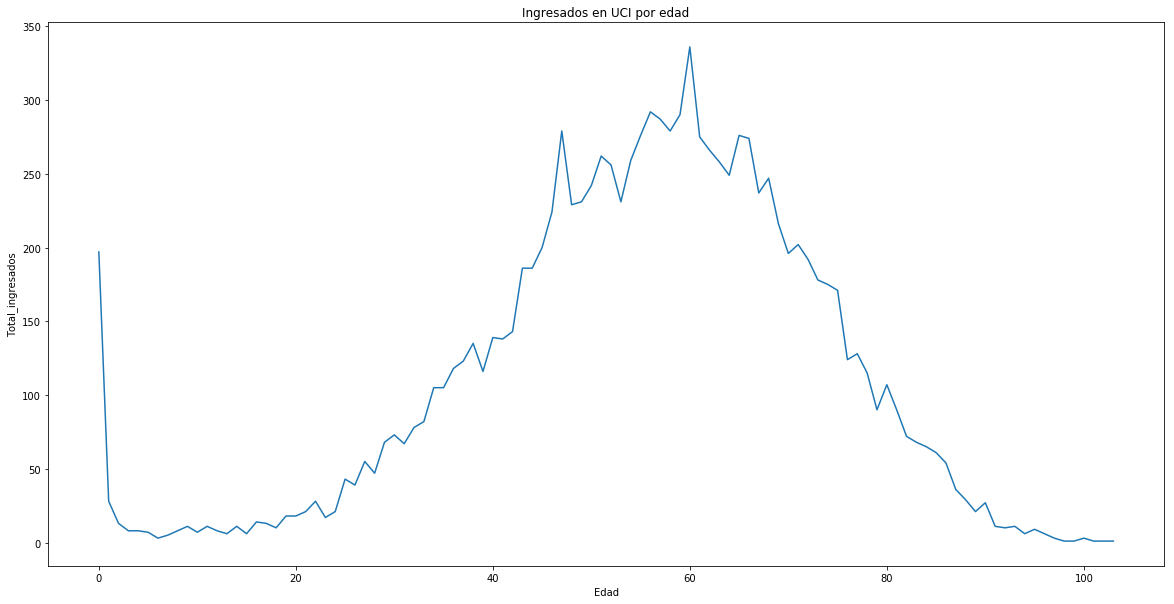

In [31]:
#Realizad la gráfica
plt.figure(figsize=(20,10)) 
plt.plot('EDAD', 'TOTAL_INGRESADOS', data=ingresados_uci)
plt.title('Ingresados en UCI por edad')
plt.xlabel('Edad')
plt.ylabel('Total_ingresados')
plt.show()

**Realiza una gráfica en la que se vea el numero de pacientes fallecidos por edad. Para saber si un paciente ha fallecido la fecha de defunción tiene que ser distinta a 9999-99-99**

In [32]:
fallecidos = data.loc[data['FECHA_DEF'] != '9999-99-99'].groupby('EDAD')['FECHA_DEF'].agg({'TOTAL_FALLECIDOS': 'count'}).reset_index()
fallecidos.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,EDAD,TOTAL_FALLECIDOS
0,0,56
1,1,38
2,2,8
3,3,10
4,4,5


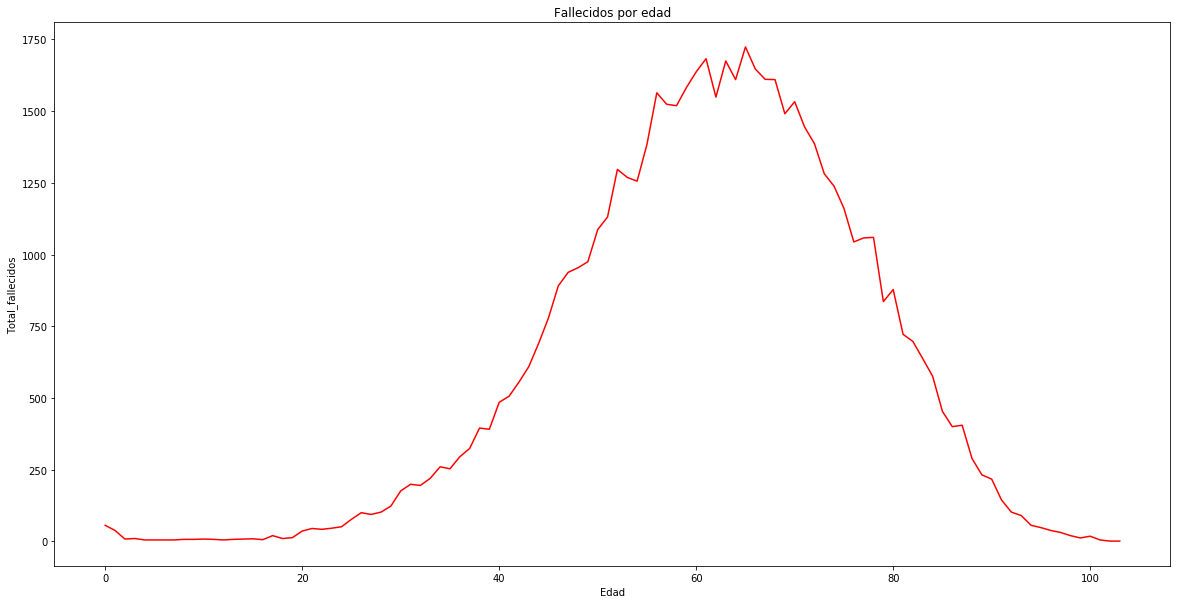

In [33]:
#Realizad la gráfica

plt.figure(figsize=(20,10)) 
plt.plot('EDAD', 'TOTAL_FALLECIDOS', data=fallecidos, color='red')
plt.title('Fallecidos por edad')
plt.xlabel('Edad')
plt.ylabel('Total_fallecidos')
plt.show()

**Muestra en una gráfica cuantos pacientes tienen cada una de las comorbilidades (diabetes, epoc, asma, ...) sobre el total de los pacientes.**

In [34]:
import pandas as pd

enfermedad_total =  pd.DataFrame(columns=['enfermedad', 'total'])
comorbilidades = ["DIABETES", "EPOC", "ASMA", "INMUSUPR", "HIPERTENSION", "OTRA_COM", "CARDIOVASCULAR", "OBESIDAD", "RENAL_CRONICA"]
for enfermedad in comorbilidades:
    total = len(data.loc[data[enfermedad] == 1])
    registro = {'enfermedad': enfermedad,  'total': total}
    enfermedad_total = enfermedad_total.append(registro, ignore_index=True)
    
enfermedad_total.head(10)    

,enfermedad,total
0,DIABETES,72399
1,EPOC,7094
2,ASMA,12098
3,INMUSUPR,5404
4,HIPERTENSION,89823
5,OTRA_COM,11497
6,CARDIOVASCULAR,9582
7,OBESIDAD,85075
8,RENAL_CRONICA,9017


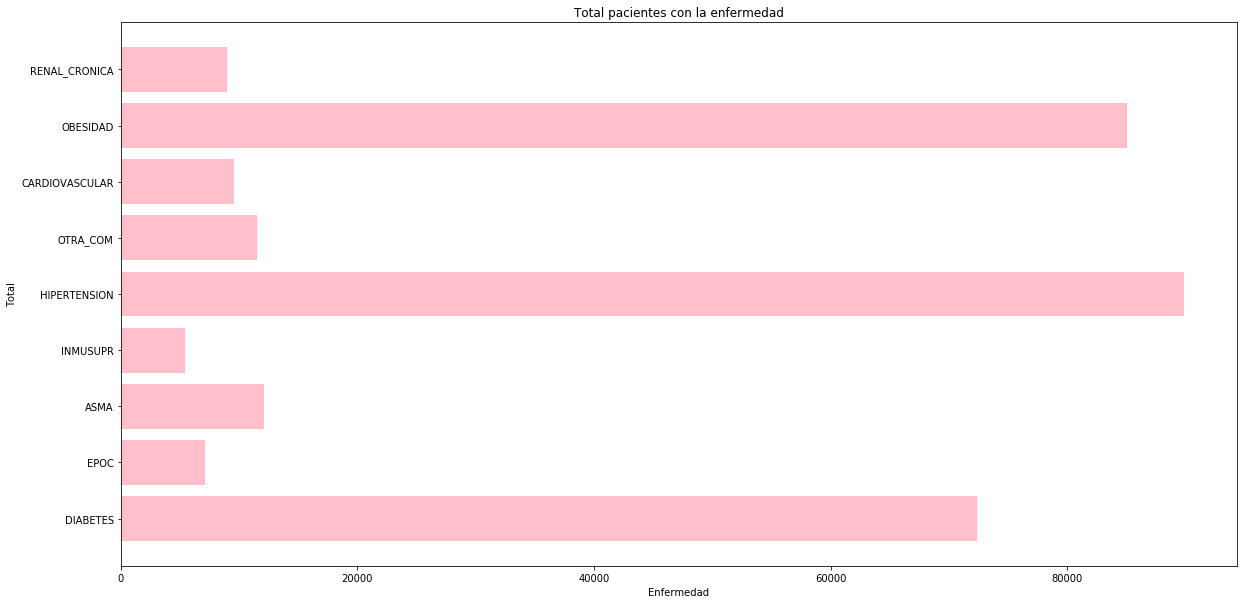

In [35]:
plt.figure(figsize=(20,10)) 
plt.barh('enfermedad', 'total', data=enfermedad_total, color='pink')
plt.title('Total pacientes con la enfermedad')
plt.xlabel('Enfermedad')
plt.ylabel('Total')
plt.show()

## REGRESIÓN LOGISTICA

A continuación vamos a realizar una regresión logistica con spark con la intención de predecir el ingreso en UCI de los pacientes en función de sus caracteristicas clínicas. Os proponemos un esuqema de cómo hacerlo pero no es la única forma de realizarlo, podeis hacerlo de otra forma si lo considerais.

**En primer lugar vamos a preparar los datos utilizando la función VectorAssembler https://spark.apache.org/docs/latest/ml-features.html#vectorassembler** Las features de nuestro modelo serán ["SEXO","EDAD","DIABETES","EPOC","ASMA","INMUSUPR","HIPERTENSION","OTRA_COM","CARDIOVASCULAR","OBESIDAD","RENAL_CRONICA"] y la variable objetivo UCI. Igualad el resultado a nuevo dataframe.

In [36]:
from pyspark.ml.feature import VectorAssembler

# Crear objeto Assembler
assembler = VectorAssembler(inputCols=[
    "SEXO","EDAD","DIABETES","EPOC","ASMA","INMUSUPR","HIPERTENSION","OTRA_COM","CARDIOVASCULAR","OBESIDAD","RENAL_CRONICA"
], outputCol = 'features')

# Consolidar columnas predictoras
df_assembled = assembler.transform(df)

In [37]:
# Agreamos una nueva columna llamada label  utilizando los valores de la columna UCI.
df_assembled = df_assembled.withColumn("label", df["UCI"])
df_assembled.show(5)

+----+----+----------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+--------------------+-----+
|SEXO|EDAD| FECHA_DEF|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|UCI|            features|label|
+----+----+----------+--------+----+----+--------+------------+--------+--------------+--------+-------------+---+--------------------+-----+
|   2|  47|9999-99-99|       1|   2|   2|       2|           2|       2|             2|       2|            2|  2|[2.0,47.0,1.0,2.0...|    2|
|   2|  54|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2|  2|[2.0,54.0,2.0,2.0...|    2|
|   1|  26|9999-99-99|       2|   2|   2|       2|           2|       2|             2|       2|            2|  2|[1.0,26.0,2.0,2.0...|    2|
|   1|  32|9999-99-99|       1|   2|   2|       2|           1|       2|             2|       2|            2|  2|[1.0,32.0,1.0,2.0...|    2|
|   1|

In [38]:
# El dataframe final tendra unicamente las columnas  features y label.(**Importante que el conjunto de datos final tenga una columna llamada label, para que al aplicar entrenar el modelo,
# no se muestre un error, porque no se encuentra la columna 'label')
df_final = df_assembled.select('features', 'label')

In [39]:
df_final.show(5, truncate = False)

+----------------------------------------------+-----+
|features                                      |label|
+----------------------------------------------+-----+
|[2.0,47.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|2    |
|[2.0,54.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|2    |
|[1.0,26.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|2    |
|[1.0,32.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0]|2    |
|[1.0,43.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|2    |
+----------------------------------------------+-----+
only showing top 5 rows



**Vamos a dividir en dataset en conjunto de test y de entrenamiento, utilizad la función randomSplit https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.randomSplit.html**

In [40]:
#Dividid los datos en conjunto de entrenamiento y test y mostrad por pantalla un count de cada uno de los dos nuevos dataframes.
df_train, df_test = df_final.randomSplit([0.8, 0.2], seed = 24)

In [41]:
print('Nº Filas del conjunto de entrenamiento:',df_train.count())

Nº Filas del conjunto de entrenamiento: 363885


In [42]:
print('Nº Filas del conjunto de test:', df_test.count())

Nº Filas del conjunto de test: 90818


**A continuación entrenamos la Regresión Logistica utilizando la función LogisticRegression https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression**

In [43]:
#En esta celda entrenad la regresión logistica
from pyspark.ml.classification import LogisticRegression

# crear un objeto clasificador
logistic = LogisticRegression()
# Entrenar modelo con datos de entrenamiento.
log_reg = logistic.fit(df_train)

In [44]:
#En esta celda, utilizando el modelo que acabais de crar, realizad las predicciones para el conjunto de test y mostrad algunos de los resultados por pantalla. 

# Obtener predicciones con los datos de test.
prediction = log_reg.transform(df_test)

In [45]:
prediction.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,0.0,1.0,2.0,...|    2|[-33.606968704472...|[8.31984707272361...|       2.0|
|[1.0,0.0,1.0,2.0,...|    2|[-34.950253684298...|[1.21979448570236...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-32.014896145805...|[9.70879424927754...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-32.014896145805...|[9.70879424927754...|       2.0|
|[1.0,0.0,2.0,2.0,...|    2|[-32.014896145805...|[9.70879424927754...|       2.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [46]:
prediction.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       2.0| 2294|
|    2|       2.0|88524|
+-----+----------+-----+



In [47]:
#Haced un count de los valores de la variable predicha UCI.
prediction.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       2.0|90818|
+----------+-----+



**¿Qué ha occurido y por qué? ¿Hay algún error en la predicción que estamos haciendo? En caso de que lo haya explica cómo lo solucionariais y vuelve a entrenar la regresión solucionando el problema**

PISTA: ¿El dataset está "desbalanceado"? **Completa esta celda explicando qué significa que el dataset esté desbalanceado, por qué lo está o no lo está, y como se arregla en caso de estarlo**

In [48]:
#Demostrad si el dataset esta desbalanceado o no

# Respuesta: Si analizamos la columna UCI del conjunto de datos df_final, podemos ver claramente que de las 454703 filas que tiene el conjunto de datos, 11278  representan 
# la etiqueta 1(UCI = Si) y 443425 representan la etiqueta 2(UCI = No). Se aprecia sin ningun tipo de duda que el conjunto de datos esta muy desbalanceado. Si entrenamos un modelo 
# con datos desbalanceados  donde predomina más una etqueta que otra, obtenemos como hemos visto en el caso anterior una prediccion muy mala, ya que no es capaz de predecir corretamente.
# Si nuestro conjunto de datos de entramiento tiene 363885 filas, las filas de entrenamiento con etiqueta 1 van a ser muy pocas con respecto a la etiqueta 2. 
# El modelo ha sido entrenado con datos sesgados. Además nuestro conjunto de datos de test tiene 90818 filas (de las cuales se observa que el modelo predice 2294 filas 
# de la etiqueta 1 como etiqueta 2 y el resto  88524 las predichas como etqueta 2. No es capaz de dintinguir entre etiqueta 1 y 2, para el modelo todas son de tipo 2.

df_final.show(5)
df_final.groupby('label').count().show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.0,47.0,1.0,2.0...|    2|
|[2.0,54.0,2.0,2.0...|    2|
|[1.0,26.0,2.0,2.0...|    2|
|[1.0,32.0,1.0,2.0...|    2|
|[1.0,43.0,2.0,2.0...|    2|
+--------------------+-----+
only showing top 5 rows

+-----+------+
|label| count|
+-----+------+
|    1| 11278|
|    2|443425|
+-----+------+



In [49]:
# ¿Como solucinar que el conjunto de datos esté desbalanceado?

# Generar dos dataframes, filtrando el tipo de etiqueta de la columna label.
# Dataframe 1, label = 1.
df_lab1= df_final.where(col('label') == 1)
df_lab1.show(3, truncate=False)
print(df_lab1.count())

# Dataframe 2, label = 2.
df_lab2= df_final.where(col('label') == 2)
df_lab2.show(3, truncate=False)
print(df_lab2.count())

+----------------------------------------------+-----+
|features                                      |label|
+----------------------------------------------+-----+
|[2.0,60.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|1    |
|[2.0,59.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|1    |
|[2.0,69.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|1    |
+----------------------------------------------+-----+
only showing top 3 rows

11278
+----------------------------------------------+-----+
|features                                      |label|
+----------------------------------------------+-----+
|[2.0,47.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|2    |
|[2.0,54.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|2    |
|[1.0,26.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]|2    |
+----------------------------------------------+-----+
only showing top 3 rows

443425


In [50]:
# Obtener una muestra aleatoria de cada DataFrame
# el valor  para el parametro fraction  es obtener la relación entre el tamaño deseado de la muestra y el tamaño original
# el valor de fraction esta comprendido entre un rango entre [0.0, 1.0].

sample_df_lab1 = df_lab1.sample(fraction=df_lab1.count()/df_lab1.count(), seed = 15)
print('La muestra obtenida para Dataframe 1 tiene {} filas'.format(sample_df_lab1.count()))

sample_df_lab2 = df_lab2.sample(fraction=df_lab1.count()/df_lab2.count(), seed = 15)
print('La muestra obtenida para Dataframe 2 tiene {} filas'.format(sample_df_lab2.count()))

print('Ahora si, existe una proporcion de muestras similar entre el dataset 1 y el dataset 2.')

La muestra obtenida para Dataframe 1 tiene 11278 filas
La muestra obtenida para Dataframe 2 tiene 11211 filas
Ahora si, existe una proporcion de muestras similar entre el dataset 1 y el dataset 2.


In [51]:
# Unimos las filas del Dataframe 1 con el DataFrame 2.
df_balanceado = sample_df_lab1.union(sample_df_lab2)
df_balanceado.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|11278|
|    2|11211|
+-----+-----+



In [52]:
# Dividimos los datos en un conjunto de entrenamiento y test 
df_b_train, df_b_test = df_balanceado.randomSplit([0.8, 0.2], seed = 24)
print('Nº Filas del conjunto de entrenamiento balanceado:',df_b_train.count())
print('Nº Filas del conjunto de test balanceado:', df_b_test.count())

Nº Filas del conjunto de entrenamiento balanceado: 18014
Nº Filas del conjunto de test balanceado: 4475


In [53]:
# Ahora el modelo se va a entrenar con datos de entrenamiento balanceados:   9042 filas (label = 1) y 8972 filas (label = 2)
df_b_train.groupby('label').count().show() 

+-----+-----+
|label|count|
+-----+-----+
|    1| 9042|
|    2| 8972|
+-----+-----+



In [54]:
# La prediccion se va a hacer con datos de test balanceados: 2236 filas (label = 1) y 2239 filas (label = 2) 
df_b_test.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2236|
|    2| 2239|
+-----+-----+



In [55]:
#En esta celda entrenad la regresión logistica
from pyspark.ml.classification import LogisticRegression

# crear un objeto clasificador
logistic_b = LogisticRegression()
# Entrenar modelo con datos de entrenamiento.
log_reg_b = logistic_b.fit(df_b_train)

In [56]:
# Obtener predicciones con los datos de test.
prediction_b = log_reg_b.transform(df_b_test)
prediction_b.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,0.0,2.0,2.0,...|    1|[-51.398231226814...|[1.33909106002189...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-51.398231226814...|[1.33909106002189...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-53.646576380361...|[4.10867905359801...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-53.646576380361...|[4.10867905359801...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-56.951071516892...|[2.48939801646141...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-56.951071516892...|[2.48939801646141...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-56.951071516892...|[2.48939801646141...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-56.951071516892...|[2.48939801646141...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[-56.951071516892...|[2.48939801646141...|       2.0|
|[1.0,0.0,2.0,2.

**Por último vamos a analizar las métricas del modelo, se pide ver el *Accuracy* del modelo y la matriz de confusión** 

In [57]:
# Matriz de confusion:
prediction_b.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    2|       1.0|  752|
|    1|       2.0|  693|
|    2|       2.0| 1487|
|    1|       1.0| 1543|
+-----+----------+-----+



In [58]:
TP = prediction_b.filter('prediction = 1 AND label = prediction').count()
TN = prediction_b.filter('prediction = 2 AND label = prediction').count()
FP = prediction_b.filter('prediction = 1 AND label = 2').count()
FN = prediction_b.filter('prediction = 2 AND label = 1').count()

accuracy = (TN +TP) / (TN+TP+FN+FP)
print("Accuracy : ",accuracy)

Accuracy :  0.6770949720670391


**Conclusiones:**

Con respecto a los datos obtenidos en la matriz de confusion se obtienen los siguientes resultados:

* Verdaderos Postivos (TP) :  El modelo predice un resultado positivo(1) y la etiqueta conocida es positiva(1). El modelo predice 1543  verdaderos positivos.
* Verdaderos Negativos (TN) : El modelo predice un resultado negativo(2) y la etiqueta conocida es negativa(2). El modelo predice 1487 verdaderos negativos.
* Falsos Postivos (FP) :  El modelo predice un resultado positivo(1) y la etiqueta conocida es negativa(2). El modelo predice 752 falsos positivos.
* Falsos Negativos (TN) : El modelo predice un resultado negativo(2) y la etiqueta conocida es postiva(1). El modelo predice 693 falsos negativos.

El modelo obtiene un 67% de predicciones correctas respecto al total.

In [59]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

prediction_Labels = log_reg_b.transform(df_b_test).select('prediction', 'label')

In [60]:
# Importante: el formato esperado de la funcion MulticlassMetrics espera un RDD o lista con tuplas que sigan el formato (prediction, label), además el tipo de dato  de prediction y 
# label debe ser el mismo.

# Crear un objeto MulticlassMetrics
metrics = MulticlassMetrics(prediction_Labels.rdd.map((lambda x: tuple(map(float, x)))))

# métricas de evaluación,  matriz de confusión
print(metrics.confusionMatrix().toArray())

[[1543.  693.]
 [ 752. 1487.]]


**Otras métricas:**

In [61]:
# Precisión : proporción de predicciones correctas entre todas las predicciones positivas
precision = metrics.precision()

# Exactitud(Accuracy): proporción de predicciones correctas en relación con todas las predicciones realizadas.
# El accuracy  puede ser una medida engañosa en casos donde las clases no están balanceadas. 
# Ej.: si tienes un conjunto de datos en el que el 90% de las instancias pertenecen a la clase A y el 10% a la clase B, 
# un modelo que siempre predice la clase A obtendrá una precisión del 90%, obtienes un valor alto, pero no es útil, ya que la prediccion no es correcta.

accuracy = metrics.accuracy

# Recall:  proporción de predicciones correctas entre todas las instancias positivas reales
recall = metrics.recall()

# F1-score(Fmeasure) es una métrica más adecuada; esta métrica combina la precision y el recall en un solo valor.
f_measure = metrics.fMeasure()


print("Precisión:", precision)
print("Exactitud (Accuracy):", accuracy)
print("Recall:", recall)
print("F1-score(F-Measure):", f_measure)

Precisión: 0.6770949720670391
Exactitud (Accuracy): 0.6770949720670391
Recall: 0.6770949720670391
F1-score(F-Measure): 0.6770949720670391


## ARBOL DE DECISIÓN

**Por último, para acabar la práctica, vamos a repetir la predicción que hemos hecho anteriormente, pero utilizando otro tipo de modelo, en este caso un árbol de decisión. Podeis encointrar documentación sobre los árboles aquí: https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier**

In [62]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crear objeto Decision Tree Classifier
tree = DecisionTreeClassifier()

# Entrenar modelo con datos de entrenamiento balanceado
tree_model = tree.fit(df_b_train)

# Obtener predicciones con los datos de test.
prediction_tree= tree_model.transform(df_b_test)
prediction_tree.show()

+--------------------+-----+-----------------+--------------------+----------+
|            features|label|    rawPrediction|         probability|prediction|
+--------------------+-----+-----------------+--------------------+----------+
|[1.0,0.0,2.0,2.0,...|    1|   [0.0,35.0,1.0]|[0.0,0.9722222222...|       1.0|
|[1.0,0.0,2.0,2.0,...|    1|   [0.0,35.0,1.0]|[0.0,0.9722222222...|       1.0|
|[1.0,0.0,2.0,2.0,...|    1|   [0.0,35.0,5.0]|   [0.0,0.875,0.125]|       1.0|
|[1.0,0.0,2.0,2.0,...|    1|   [0.0,35.0,5.0]|   [0.0,0.875,0.125]|       1.0|
|[1.0,0.0,2.0,2.0,...|    1|[0.0,245.0,275.0]|[0.0,0.4711538461...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[0.0,245.0,275.0]|[0.0,0.4711538461...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[0.0,245.0,275.0]|[0.0,0.4711538461...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[0.0,245.0,275.0]|[0.0,0.4711538461...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[0.0,245.0,275.0]|[0.0,0.4711538461...|       2.0|
|[1.0,0.0,2.0,2.0,...|    1|[0.0,245.0,275.0]|[0.0,0

**Explica el output del modelo, explica el arbol de decisión importante, cuales serian las variables que predicirian el ingreso en UCI de un paciente** Utilizad la función *toDebugString*.

In [63]:
# toDebugString - devuelve una representación del arbol de decision que muestra las reglas decision que ha usado el modelo para clasificar los pacientes que ingresan en UCI.

print(tree_model.toDebugString)


DecisionTreeClassificationModel (uid=DecisionTreeClassifier_f22c2ccbc389) of depth 5 with 35 nodes
  If (feature 1 <= 44.5)
   If (feature 2 <= 1.5)
    If (feature 1 <= 19.5)
     If (feature 9 <= 1.5)
      If (feature 0 <= 1.5)
       Predict: 1.0
      Else (feature 0 > 1.5)
       Predict: 2.0
     Else (feature 9 > 1.5)
      Predict: 1.0
    Else (feature 1 > 19.5)
     If (feature 1 <= 35.5)
      If (feature 9 <= 1.5)
       Predict: 2.0
      Else (feature 9 > 1.5)
       Predict: 1.0
     Else (feature 1 > 35.5)
      Predict: 1.0
   Else (feature 2 > 1.5)
    If (feature 1 <= 19.5)
     If (feature 5 <= 1.5)
      Predict: 1.0
     Else (feature 5 > 1.5)
      If (feature 7 <= 1.5)
       Predict: 1.0
      Else (feature 7 > 1.5)
       Predict: 2.0
    Else (feature 1 > 19.5)
     Predict: 2.0
  Else (feature 1 > 44.5)
   If (feature 1 <= 57.5)
    If (feature 2 <= 1.5)
     Predict: 1.0
    Else (feature 2 > 1.5)
     If (feature 0 <= 1.5)
      If (feature 9 <= 1.5)
    

**Tras realizar un representación manual  de las reglas de decision se observa:**

![Representacion Arbol de Decision.png](../images/Representacion_Decision_Tree.png)

**En esta celda explica en texto el output del árbol**

- Una persona con 57.5 años o menos sin diabetes, mujer con obesidad si ingresa en UCI.
- Una persona con 57.5 años o menos sin diabetes, mujer sin obesidad no ingresa en UCI.
- Una persona con 57.5 años o menos sin diabetes y hombre si ingresa en UCI.
- Una persona con 57.5 años o menos con diabetes si ingresa en UCI.
- Una persona mayor de 44.5 años o mayor de 57.5 años con diabetes  y menor de 59.5 años con  insuficiencia renal crónica no ingresa en UCI.
- Una persona mayor de 44.5 años o mayor de 57.5 años con diabetes  y menor de 59.5 años sin  insuficiencia renal crónica si ingresa en UCI.
- Una persona mayor de 44.5 años o mayor de 57.5 años con diabetes  y mayor de 59.5 años si ingresa en UCI.
- Una persona mayor de 44.5 años o mayor de 57.5 años sin diabetes si ingresa en UCI.
- Una persona con 44.5 o menos y mayor de 19,5 años sin diabetes  no ingresa en UCI.
- Una persona con 44.5 o menos y menor de 19,5 años con inmunosupresión si ingresa en UCI.
- Una persona con 44.5 o menos y menor de 19,5 años sin inmunosupresión sin otras enfermedades no ingresa en UCI.
- Una persona con 44.5 o menos y menor de 19,5 años sin inmunosupresión pero con otras enfermedades si ingresa en UCI.
- Una persona con 44.5  con diabetes y menor de 19.5 años, con obsesidad y mujer si ingresa en UCI.
- Una persona con 44.5  con diabetes y menor de 19.5 años, sin obsesidad si ingresa en UCI.
- Una persona con 44.5  con diabetes y menor de 19.5 años, con obsesidad y hombre, no ingresa en UCI.
- Una persona con 44.5  con diabetes y menor de 19.5 años, con obsesidad y mujer, si ingresa en UCI.

- Una persona con 44.5 o menos , con diabetes, mayor de 19.5 años o mayor de 35.5 si ingresa en UCI.
- Una persona con 44.5 o menos , con diabetes, mayor de 19.5 años pero menor de 35.5, sin obesidad si ingresa en UCI.
- Una persona con 44.5 o menos , con diabetes, mayor de 19.5 años pero menor de 35.5, con obesidad no ingresa en UCI.


**Conclusiones:**

Las variables más importantes que predicirian el ingreso en UCI de un paciente sería la edad, diabetes, sexo, obesidad, inmusupr, renal_cronica y otra_com.
Se obseva que edad, diabetes y obsesidad son factores determinantes para decidir si el paciente será ingresado o no.

**Para finalizar la práctica vamos a analizar las métricas del árbol, se pide ver el *Accuracy* del modelo y la matriz de confusión** 

In [64]:
# Matriz de confusion:
prediction_tree.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    2|       1.0|  932|
|    1|       2.0|  484|
|    2|       2.0| 1307|
|    1|       1.0| 1752|
+-----+----------+-----+



In [132]:
TP = prediction_tree.filter('prediction = 1 AND label = prediction').count()
TN = prediction_tree.filter('prediction = 2 AND label = prediction').count()
FP = prediction_tree.filter('prediction = 1 AND label = 2').count()
FN = prediction_tree.filter('prediction = 2 AND label = 1').count()

accuracy = (TN +TP) / (TN+TP+FN+FP)
print("Accuracy : ",accuracy)

Accuracy :  0.6862569832402234


**Conclusiones:**

Con respecto a los datos obtenidos en la matriz de confusion se obtienen los siguientes resultados:

* Verdaderos Postivos (TP) :  El modelo predice un resultado positivo(1) y la etiqueta conocida es positiva(1). El modelo predice 1751  verdaderos positivos.
* Verdaderos Negativos (TN) : El modelo predice un resultado negativo(2) y la etiqueta conocida es negativa(2). El modelo predice 1320 verdaderos negativos.
* Falsos Postivos (FP) :  El modelo predice un resultado positivo(1) y la etiqueta conocida es negativa(2). El modelo predice 919 falsos positivos.
* Falsos Negativos (TN) : El modelo predice un resultado negativo(2) y la etiqueta conocida es postiva(1). El modelo predice 485 falsos negativos.

El modelo obtiene un 68.6% de predicciones correctas respecto al total. Este porcentaje implica que el modelo puede mejorar sus metricas. 
Entrenar el modelo con una muestra  balanceda más amplia a la que hemos utilizado, seguramente, permitiria al modelo  predecir mejor y por tanto mejorar sus métricas.